In [1]:
import gym
import numpy as np
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)

In [3]:
# Very simple model, but enough to learn the enviornment
model_size = 4
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], model_size, bias=False),
    nn.Linear(model_size, env.action_space.n, bias=False)
)

In [4]:
def qval(model, state):
    return model(Variable(torch.from_numpy(state).type(torch.FloatTensor)))

In [5]:
def scale(x, mn, mx):
    return (x - mn) / (mx - mn)

In [6]:
# Parameters
state = env.reset()
eps = 0.3
eps_decay = 0.6
gamma = 0.99
episodes = 50
learning_rate = 0.001

# History
successes = 0
loss_history = []
reward_history = []
position_history = []


loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

try:
    for episode in tqdm(range(episodes)):
        episode_loss = 0
        episode_reward = 0
        state = env.reset()
        done = False
        while not done:
            if False:
                env.render()

            q = qval(model, state)

            # eps-exploration
            if np.random.rand() < eps:
                action = np.random.randint(0,3)
            else:
                _, action = torch.max(q, -1)
                action = action.item()

            state_1, reward, done, _ = env.step(action)
            (pos, vel) = state_1

            # Default reaward is a constant of -1, and total reward is a total of -200 unless model already succeeds on the task
            # Replace reward with car's position (rescaled to [-1; 0]). Maximizing position must maximize discrete reward as well
            reward = scale(pos, env.observation_space.low[0], env.observation_space.high[0]) - 1

            
            best_future, _ = torch.max(qval(model, state_1), -1)


            new_q = Variable(q.clone())
            new_q[action] = reward + gamma * best_future.detach()

            loss = loss_fn(q, new_q)

            model.zero_grad()
            loss.backward()
            optimizer.step()

            episode_loss += loss.item()
            episode_reward += reward
            state = state_1
            
        # Reduce exploration only on success, to incentivise initial discovery
        if pos >= 0.5:
            eps *= eps_decay

            scheduler.step()

            successes += 1
        # Record history
        loss_history.append(episode_loss)
        reward_history.append(episode_reward)
        position_history.append(pos)
            
finally:
    env.close()

print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.68it/s]

successful episodes: 35 - 70.0000%


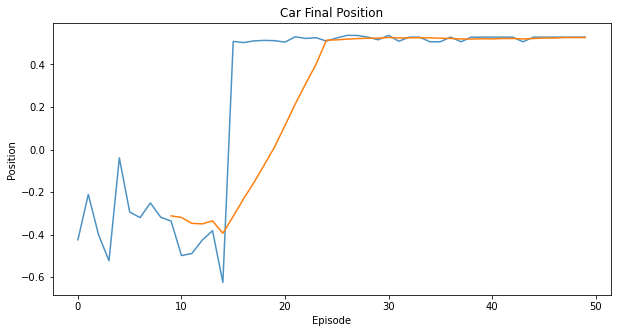

In [7]:
plt.figure(2, figsize=(10,5))
p = pd.Series(position_history)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position - Modified.png')
plt.show()

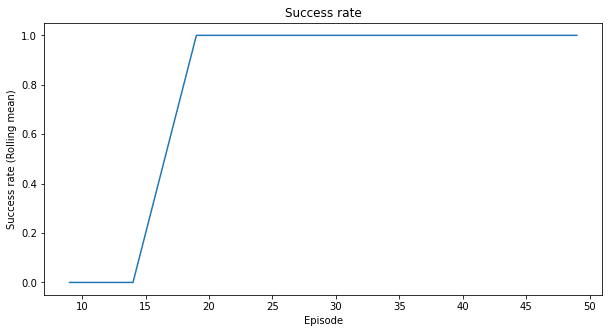

In [8]:
plt.figure(figsize=(10, 5))
sc = p >= 0.5
ms = sc[5:].rolling(5).mean()
plt.plot(ms)
plt.xlabel("Episode")
plt.ylabel("Success rate (Rolling mean)")
plt.title("Success rate")
plt.show()